In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### A Framework for Action Recognition 


In [2]:
!pip install pafy youtube-dl moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
from moviepy.editor import *
%matplotlib inline
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# New Section

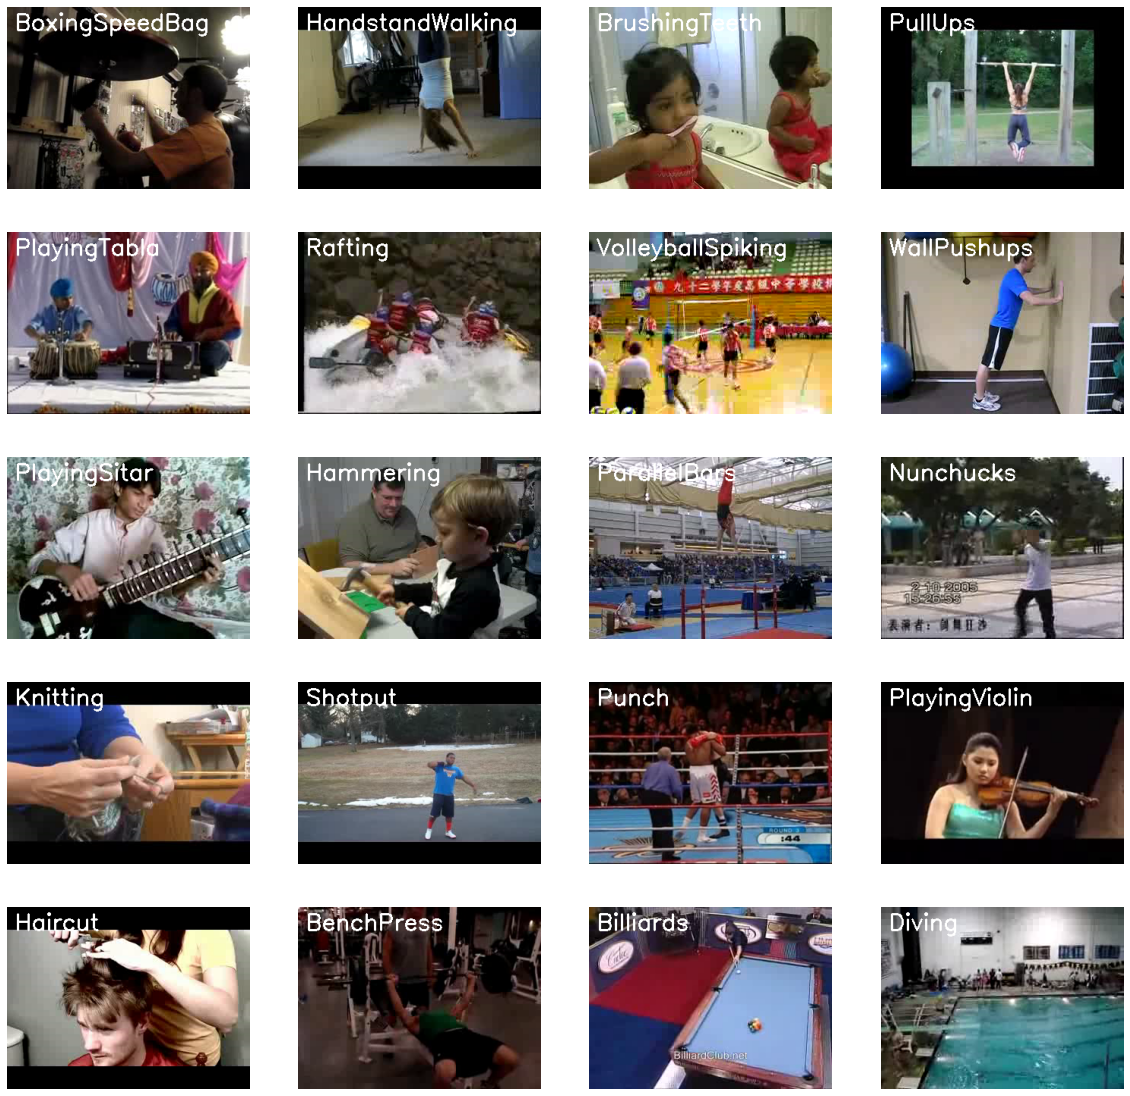

In [5]:
plt.figure(figsize = (20, 20))
 
datapath="/content/drive/MyDrive/UCF-101"
all_classes_names = os.listdir(datapath)
 
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'{datapath}/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{datapath}/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
# print(all_classes_names)
# myclass=['PushUps', 'PlayingGuitar', 'Drumming',
#          'Bowling',  'Basketball','Biking' ]

In [6]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "/content/drive/MyDrive/UCF-101"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST =['PlayingCello', 'PlayingGuitar', 'PlayingDhol',
         'PlayingFlute', 'PlayingPiano', 'PlayingSitar',
         'PlayingTabla','PlayingViolin','PlayingDaf','Drumming']

In [7]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [8]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [9]:

# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: PlayingCello
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: PlayingDhol
Extracting Data of Class: PlayingFlute
Extracting Data of Class: PlayingPiano
Extracting Data of Class: PlayingSitar
Extracting Data of Class: PlayingTabla
Extracting Data of Class: PlayingViolin
Extracting Data of Class: PlayingDaf
Extracting Data of Class: Drumming


In [10]:

# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [11]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
# features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,  test_size = 0.2, shuffle = True, random_state = seed_constant)


In [11]:
# Split the Data into Train ( 70% ) and Test Set ( 30% ).
# features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,  test_size = 0.3, shuffle = True, random_state = seed_constant)


In [20]:
# Split the Data into Train ( 60% ) and Test Set ( 40% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,  test_size = 0.4, shuffle = True, random_state = seed_constant)


In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model
    

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

In [ ]:
!pip install pyyaml h5py 

In [ ]:
convlstm_model.save('/content/drive/MyDrive/cnn+lstm_models/convlstm_70_30.h5')


In [21]:
convlstm_model = tf.keras.models.load_model('/content/drive/MyDrive/cnn+lstm_models/convlstm_60_40.h5')
# Check its architecture


In [22]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

18/18 [==============================] - 3s 93ms/step - loss: 0.5552 - accuracy: 0.8624


In [23]:
predi_of_features_test = convlstm_model.predict(features_test);

In [24]:
y_pred_labels = np.argmax(predi_of_features_test, axis=1) 

In [15]:
y_pred_labels

array([2, 0, 5, 2, 6, 1, 1, 5, 5, 9, 8, 7, 9, 1, 7, 3, 7, 8, 0, 9, 0, 2,
       0, 3, 2, 2, 0, 2, 3, 7, 8, 8, 3, 2, 0, 1, 9, 0, 2, 5, 5, 1, 9, 2,
       4, 5, 3, 9, 5, 4, 5, 0, 3, 1, 8, 1, 0, 8, 6, 9, 0, 2, 4, 5, 4, 3,
       1, 0, 4, 1, 4, 1, 2, 4, 4, 2, 9, 8, 4, 3, 5, 9, 3, 8, 2, 5, 5, 0,
       2, 8, 8, 8, 3, 3, 7, 3, 3, 1, 7, 0, 5, 6, 1, 3, 0, 6, 1, 3, 1, 9,
       1, 8, 8, 3, 2, 5, 2, 0, 5, 6, 5, 4, 4, 3, 6, 6, 3, 3, 6, 2, 7, 6,
       9, 2, 2, 6, 2, 8, 9, 0, 0, 9, 7, 1, 5, 2, 0, 5, 7, 4, 7, 6, 6, 4,
       5, 6, 1, 6, 6, 3, 3, 5, 4, 9, 6, 1, 1, 5, 7, 1, 8, 7, 9, 8, 8, 5,
       0, 4, 8, 2, 3, 0, 9, 0, 0, 4, 9, 8, 0, 3, 5, 6, 7, 3, 6, 9, 1, 1,
       2, 7, 8, 9, 6, 9, 2, 2, 3, 8, 2, 6, 2, 1, 7, 7, 6, 3, 2, 7, 5, 0,
       1, 4, 5, 1, 9, 5, 4, 8, 1, 2, 5, 2, 9, 3, 8, 5, 8, 3, 0, 3, 3, 0,
       3, 2, 0, 0, 4, 7, 1, 6, 0, 8, 9, 3, 2, 7, 0, 0, 5, 6, 3, 6, 6, 8,
       2, 5, 2, 6, 0, 9, 4, 1, 1, 8, 1, 8, 4, 1, 7, 5, 2, 0, 9, 2, 9, 1,
       2, 6, 7, 0, 6, 8, 5, 8, 4, 3, 1, 7, 8, 0, 3,

In [25]:
labels_test_classes=np.argmax(labels_test, axis=1) 

In [18]:
labels_test_classes

array([2, 3, 5, 2, 6, 1, 1, 5, 0, 9, 1, 7, 9, 1, 7, 3, 7, 8, 0, 9, 0, 0,
       0, 3, 2, 2, 0, 2, 4, 9, 8, 8, 3, 2, 0, 1, 9, 0, 2, 5, 5, 1, 9, 2,
       4, 5, 3, 9, 2, 4, 5, 0, 3, 1, 8, 1, 0, 8, 6, 9, 0, 2, 4, 1, 4, 3,
       1, 0, 4, 1, 4, 4, 2, 4, 4, 2, 9, 8, 4, 3, 5, 9, 3, 8, 2, 5, 5, 0,
       2, 8, 8, 8, 3, 3, 7, 3, 3, 1, 7, 0, 5, 6, 1, 3, 0, 6, 1, 3, 1, 9,
       1, 8, 8, 3, 2, 5, 2, 0, 5, 6, 5, 4, 2, 3, 6, 6, 3, 3, 6, 2, 7, 2,
       9, 2, 2, 6, 2, 8, 9, 5, 0, 9, 8, 1, 5, 2, 0, 5, 5, 4, 7, 6, 6, 4,
       5, 6, 1, 6, 6, 9, 3, 5, 4, 9, 6, 1, 1, 5, 9, 1, 3, 7, 9, 8, 8, 5,
       8, 4, 8, 2, 9, 0, 2, 0, 0, 4, 9, 8, 0, 4, 5, 6, 7, 3, 6, 9, 1, 1,
       2, 9, 8, 9, 6, 9, 2, 2, 3, 8, 2, 6, 2, 1, 8, 9, 6, 3, 2, 7, 5, 0,
       1, 4, 5, 1, 9, 3, 4, 8, 1, 2, 5, 0, 9, 3, 8, 0, 3, 4, 0, 5, 3, 0,
       3, 2, 0, 0, 4, 7, 1, 8, 0, 8, 9, 3, 2, 9, 2, 0, 5, 5, 3, 2, 6, 8,
       2, 5, 2, 7, 3, 9, 4, 1, 1, 2, 1, 8, 4, 1, 7, 5, 2, 0, 9, 2, 9, 7,
       2])

In [26]:
# confusion_matrix(labels_test_classes, y_pred_labels, CLASSES_LIST)
# y_true = [2, 0, 2, 2, 0, 1]
# y_pred = [0, 0, 2, 2, 0, 2]
cm = confusion_matrix(y_true=y_pred_labels, y_pred=labels_test_classes)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_LIST)
# # disp.plot()
# fig, ax = plt.subplots(figsize=(15,15))
# disp.plot(ax=ax)
# # plt.show()

In [27]:
# We will store the results in a dictionary for easy access later
per_class_accuracies = {}

# Calculate the accuracy for each one of our classes
for idx, cls in enumerate(CLASSES_LIST):
    # True negatives are all the samples that are not our current GT class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = cm[idx, idx]
    
    # The accuracy for the current class is ratio between correct predictions to all predictions
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)

In [28]:
per_class_accuracies

{'Drumming': 0.9581881533101045,
 'PlayingCello': 0.9773519163763066,
 'PlayingDaf': 0.9773519163763066,
 'PlayingDhol': 0.9686411149825784,
 'PlayingFlute': 0.9564459930313589,
 'PlayingGuitar': 0.9825783972125436,
 'PlayingPiano': 0.9878048780487805,
 'PlayingSitar': 0.9721254355400697,
 'PlayingTabla': 0.9721254355400697,
 'PlayingViolin': 0.9721254355400697}

In [ ]:
# Precision measures how accurate is your predictions. i.e. the percentage of your predictions are correct.
from sklearn.metrics import precision_score
# precision  ->   tp / (tp + fp)
precision_score(y_pred_labels, labels_test_classes, average=None)
# prec = precision_score(y_pred_labels, labels_test_classes)

array([0.87037037, 0.89090909, 0.73076923, 0.75609756, 0.61538462,
       0.8372093 , 0.89655172, 0.56521739, 0.91111111, 0.6875    ])

In [ ]:
# Recall measures how good you find all the positives. For example, we can find 80% of the possible positive cases in our top K predictions.
from sklearn.metrics import recall_score
# recall_score  ->   tp / (tp + fn)
recall_score(y_pred_labels, labels_test_classes, average=None)

array([0.81034483, 0.84482759, 0.92682927, 0.64583333, 0.88888889,
       0.81818182, 0.72222222, 0.48148148, 0.82      , 0.825     ])

In [ ]:
from sklearn.metrics import f1_score

# calculate f1_score
score = f1_score(y_pred_labels, labels_test_classes, average=None)
score

array([0.83928571, 0.86725664, 0.8172043 , 0.69662921, 0.72727273,
       0.82758621, 0.8       , 0.52      , 0.86315789, 0.75      ])

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

In [ ]:
predi_of_features_test = convlstm_model.predict(features_test);

In [ ]:
y_pred_labels = np.argmax(predi_of_features_test, axis=1) 

In [ ]:
y_pred_labels

In [ ]:
labels_test_classes=np.argmax(labels_test, axis=1) 

In [ ]:
labels_test_classes


In [ ]:
# confusion_matrix(labels_test_classes, y_pred_labels, CLASSES_LIST)
# y_true = [2, 0, 2, 2, 0, 1]
# y_pred = [0, 0, 2, 2, 0, 2]
cm = confusion_matrix(y_true=y_pred_labels, y_pred=labels_test_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_LIST)
# disp.plot()
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
# plt.show()

In [ ]:
len(labels_test_classes)

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 


In [ ]:
# def create_LRCN_model():
#     '''
#     This function will construct the required LRCN model.
#     Returns:
#         model: It is the required constructed LRCN model.
#     '''

#     # We will use a Sequential model for model construction.
#     model = Sequential()
    
#     # Define the Model Architecture.
#     ########################################################################################################################
    
#     model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
#                               input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
#     model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
#     model.add(TimeDistributed(Dropout(0.25)))
    
#     model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
#     model.add(TimeDistributed(MaxPooling2D((4, 4))))
#     model.add(TimeDistributed(Dropout(0.25)))
    
#     model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     model.add(TimeDistributed(Dropout(0.25)))
    
#     model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     #model.add(TimeDistributed(Dropout(0.25)))
                                      
#     model.add(TimeDistributed(Flatten()))
                                      
#     model.add(LSTM(32))
                                      
#     model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

#     ########################################################################################################################

#     # Display the models summary.
#     model.summary()
    
#     # Return the constructed LRCN model.
#     return model

In [ ]:
# Construct the required LRCN model.
# LRCN_model = create_LRCN_model()

# # Display the success message.
# print("Model Created Successfully!")

In [ ]:
# Plot the structure of the contructed LRCN model.
# plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
# LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
# LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

In [ ]:

# Evaluate the trained model.
# model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

In [ ]:

# Get the loss and accuracy from model_evaluation_history.
# model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()
# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# # Define a useful name for our model to make it easy for us while navigating through multiple saved models.
# model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# # Save the Model.
# LRCN_model.save(model_file_name)

In [ ]:
# Visualize the training and validation loss metrices.
# plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


In [ ]:
# Visualize the training and validation accuracy metrices.
# plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [ ]:
# def download_youtube_videos(youtube_video_url, output_directory):
#      '''
#     This function downloads the youtube video whose URL is passed to it as an argument.
#     Args:
#         youtube_video_url: URL of the video that is required to be downloaded.
#         output_directory:  The directory path to which the video needs to be stored after downloading.
#     Returns:
#         title: The title of the downloaded youtube video.
#     '''
 
#      # Create a video object which contains useful information about the video.
#      video = pafy.new(youtube_video_url)
 
#      # Retrieve the title of the video.
#      title = video.title
 
#      # Get the best available quality object for the video.
#      video_best = video.getbest()
 
#      # Construct the output file path.
#      output_file_path = f'{output_directory}/{title}.avi'
 
#      # Download the youtube video at the best available quality and store it to the contructed path.
#      video_best.download(filepath = output_file_path, quiet = True)
 
#      # Return the video title.
#      return title

In [ ]:
# import cv2
# import numpy as np

# cap = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/testvideos')

# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter('/content/drive/MyDrive/Colab Notebooks/testvideos/v3_320x240.avi',fourcc, 5, (320,240))

# while True:
#     ret, frame = cap.read()
#     if ret == True:
#         b = cv2.resize(frame,(320,240),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
#         out.write(b)
#     else:
#         break
    
# cap.release()
# out.release()
# cv2.destroyAllWindows()

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = '/content/drive/MyDrive/Colab Notebooks/testvideos'
# os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title ='g'

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.avi'

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = cnn_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255 , 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.avi'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

Output hidden; open in https://colab.research.google.com to view.

cnn features are feed to the svm function